# Comparing proportions

Let's prepare the data from thromboembolism study in a contingency table as follows:

| treatment | recurrent | no recurrence | total |
| --------- | --------- | ------------- | ----- |
| placebo   |    73     |      756      |  829  |
| Apixaban  |    14     |      826      |  840  |
| total     |    87     |     1582      | 1669  |

A contingency table displays the results of a study with a categorical outcome. Rows represent different treatments or exposures, columns represent different outcomes. Each value is an actual number of subjects.

In [94]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
table = np.array([[73, 756], [14, 826]]) # example data from page 264
# contingency table (rows = alternative treatments, cols = alternative outcomes)

In [3]:
table

array([[ 73, 756],
       [ 14, 826]])

Form a Pandas dataframe, one could obtain a contingency table e.g.:
```python
table = pd.crosstab(
	data['ed'].dropna()>2, # attention, np.nan > 2 gives False
	data['dep.cons'],
	margins=True) # margins are 'totals'
```

##  Fisher's test

The goal of the analysis is to generalize about the general population of patients who have had a thromboembolism by computing CIs and a P value. The P value answers the question
>if H0 were true, which is that the treatment **does not alter the risk** of recurrence, what is the chance that random sampling of subjects would result in incidence rates as different or more different from what we observe?

Two statistical methods can be used to compute the P value. Most would agree that the best test to use if [_Fisher's exact test_](https://en.wikipedia.org/wiki/Fisher%27s_exact_test). With large sample sizes, Fisher's test is mathematically unwiedly, so a chi-square test is used instead. With large samples, the two compute nearly identical P values.

In [4]:
odds_ratio, p_value = stats.fisher_exact(table)

print("Odds ratio\t", odds_ratio)
print("P value\t\t", p_value)

Odds ratio	 5.697089947089947
P value		 1.3340996598875717e-11


### The attributable risk

One way to summarize the results is to calculate the **difference between the two proportions** also called **attributabel risk**.

In [5]:
attributable_risk = -np.diff(table[:,0]/(table[0].sum()))[0]
print(f"attributable risk = {100*attributable_risk:.1f}%")

attributable risk = 7.1%


### The population attributable risk

While attributable risk helps us estimate the excess risk among the exposed that can be attributed to the risk factor, from a public health perspective it is often more useful to re-define the attributable risk in terms of the whole population, and thus to know the proportion of cases in the total population that can be attributed to the risk factor. For this calculation, we use the population attributable risk (PAR). Population attributable risk depends not only on the excess risk imposed by the exposure, but also on the share of the total population that is exposed:

$$ \mathrm{PAR} = p_0 - p_2 = (p_1 - p_2) \frac{n_1}{N} $$

with $p_0 = \frac{a + c}{a + b + c + d}$, the proportion of all diseases out of total.

In [6]:
# in this study 'exposed' is the placebo group
a, n1, c, n2 = 73, 829, 14, 840
N = n1 + n2 # grand total
p1 = a/n1
p2 = c/n2

print(f"population attributable risk = {100*(p1-p2)*(n1/N):.1f}%")

population attributable risk = 3.5%


### Number needed to treat

This value, i.e. the reciprocal of the attributable risk, tells you how many patients would require treatment to reduce the expected nulber of case of a defined end point by one.
Below, for every 14 patients who receive the treatment you'd expect to prevent a recurrent disease in one; the other 13 would receive no benefit from treatment.

In [7]:
print(f"NTT = {1/attributable_risk:.0f}")

NTT = 14


### Relative Risk

The **Risk Ratio** or **Relative Risk** is 8.8/1.7 i.e. 5.2. Subjects treated with placebo were 5.2 times as likely as treated patients to have a recurrent disease.
When we flip the ratio,  1.7/8.8 = 0.19, patients receiving the drug had 19% the risk of a recurrent disease than did patients receiving placebo. Beware which group is set as 'control' to interpret the RR. Here placebo is considered as 'risk' compared to the treatment with anticoagulant. When the relative risk associated with a factor is less than 1, then the factor is called a _protective factor_. Here the drug lowered the _absolute risk_ by 7.1% and reduced the _relative risk_ by 81%.

$$\mathrm{RR} = \frac{a / n_1}{c / n_2} $$

with

| treatment   | disease | no disease | total |
| ----------- | ------- | ---------- | ----- |
| exposed     |    a    |      b     |   n1  |
| not exposed |    c    |      d     |   n2  |
| total       |   m1    |     m2     |   N   | 


Therefore, the Risk Ratio is the ratio of the probability to have disease ($a$) in the exposed group ($n_1$), $p_1 = a / n_1$ to the probability to have the disease ($c$) in the not exposed group ($n_2$), $p_2 = c / n_2$.

To compute the RR we could also use $ \log\mathrm(RR) = \log(p_1) -  \log(p_2) $.

In [8]:
rr = p1 / p2
print(f"Relative Risk = {rr:.3f}")

Relative Risk = 5.283


In [9]:
np.exp(np.log(p1) - np.log(p2))

5.28347406513872

### Odds Ratio

The Risk Ratio (Relative Risk) is different from the Odds Ratio, from which is $\text{odds} = \frac{p}{1-p}$:

$$\mathrm{OR} = \frac{a/b}{c/d} = \frac{p_1 / (1 - p_1)}{p_2 / (1 - p_2)} $$

We can also use $$ \log\mathrm(OR) = \log(p_1) - \log(1 - p_1) - \log(p_2) + \log(1 - p_2) $$

In [10]:
print(f"Odds ratio = {(p1/(1-p1))/(p2/(1-p2)):.3f}")

Odds ratio = 5.697


In [11]:
b, d = 756, 826
(a/b)/(c/d)

5.697089947089947

## Confidence intervals

### 95% CI of the proportions

Computing the CI using the modified Wald method by hand as follows:

1. $p'=\frac{s+2}{n+4}$ with $s$ the number of successes and $n$ the number of trials
2. The margin of error is: $W=2\sqrt{\frac{p'(1-p')}{n+4}}$
3. Finally, the 95% CI is from $(p'-W)$ to $(p'+W)$

In [12]:
s,n = 73,829
p = (s+2)/(n+4)
W = 2 * (p * (1-p) / (n+4))**.5
print(f"The 95% CI for the {s}/{n} proprotion, i.e. {100*s/n:.1f}%, is {100*(p-W):.1f}% to {100*(p+W):.1f}% acc. Wald method.")

The 95% CI for the 73/829 proprotion, i.e. 8.8%, is 7.0% to 11.0% acc. Wald method.


In [13]:
s,n = 14,840
p = (s+2)/(n+4)
W = 2 * (p * (1-p) / (n+4))**.5
print(f"The 95% CI for the {s}/{n} proprotion, i.e. {100*s/n:.1f}%, is {100*(p-W):.1f}% to {100*(p+W):.1f}% acc. Wald method.")

The 95% CI for the 14/840 proprotion, i.e. 1.7%, is 1.0% to 2.8% acc. Wald method.


### 95% CI of the attributable risk

With the attributable risk $ \mathrm{AR} = p_1 - p_2$, the confidence interval is computing as follows:

$$\mathrm{CI} = \mathrm{AR} \pm z_{1 - \alpha/2} \times \sqrt{p(1 - p)(1/n_1 + 1/n_2)} $$

with $p = \frac{m_1}{N}$ called the risk, which is the number of adverse outcomes divided by the total number of events, and $z_{1 - \alpha/2}$ The z-value for standard normal distribution with left-tail probability.

In [14]:
ar = p1 - p2
m1 = a + c # total disease
p = m1/N # risk

conf=0.95
z = stats.norm.ppf((1 + conf) /2)

factor_ar = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

print(f"CI for the AR {attributable_risk:.5f} extends from {ar - z * factor_ar:.5f} to {ar + z * factor_ar:.5f}")
print(f"The attributable risk percent = {100*(p1 - p2)/p1:.2f}%")

CI for the AR 0.07117 extends from 0.05006 to 0.09272
The attributable risk percent = 81.07%


### CI of the NNT

The CI of the NNT is obtained by taking the reciprocal of each end of the CI of the AR.

In [15]:
print(f"CI for the NTT {1/attributable_risk:.1f} extends from {1/(ar + z*factor_ar):.2f} to {1/(ar - z*factor_ar):.2f}")

CI for the NTT 14.1 extends from 10.79 to 19.98


### CI of the relative risk

We use the following formula:

$$ \mathrm{CI} = \mathrm{RR} \pm z_{1 - \alpha/2} \times \sqrt{1/a \frac{b}{n_1} + 1/c \frac{d}{n_2}} $$

We can also use $$ \log\operatorname{Var}\mathrm(RR) = \frac{1 - p_1}{p_1} / n_1 + \frac{1 - p_2}{p_2} / n_2 $$

For tables with high number of events and 95% CI, $z_{1 - \alpha/2} \approx 1.96$

In [16]:
factor_rr = np.sqrt((1/a * b/n1) + (1/c * d/n2))
ci_rr = round(np.exp(np.log(rr) - z * factor_rr), 3), round(np.exp(np.log(rr) + z * factor_rr), 3)

print(f"CI for the RR {rr:.3f} extends from {ci_rr[0]:.3f} to {ci_rr[1]:.3f}")

CI for the RR 5.283 extends from 3.007 to 9.284


### CI of the odds ratio

To calculate the confidence interval, we use the log odds ratio, $\log(\mathrm{OR})$, and calculate its standard error:
$$ \mathrm{CI} = \log(\mathrm{OR}) \pm z_{1 - \alpha/2} \times \sqrt{1/a + 1/b + 1/c + 1/d} $$

In [17]:
factor_or = (1/a + 1/b + 1/c + 1/d)**.5
log_or = np.log(odds_ratio)
ci_or = round(np.exp(log_or - z*factor_or), 3), round(np.exp(log_or + z*factor_or), 3)
print(f"CI for the OR {odds_ratio:.3f} extends from {ci_or[0]:.3f} to {ci_or[1]:.3f}")

CI for the OR 5.697 extends from 3.189 to 10.178


### Some more toxicology data

Data in toxicology studies are often counts of events. As such they can usually be entered into table form, e.g., tumors as events in two treatment groups. A well-known statistic for evaluating the hypothesis that the tumor rate in the treated group is equal to the tumor rate in the control groups, versus the alternative hypothesis that the tumor rate is higher in the treated group (a one-sided test statistic would be used), is the Fisher's exact test. It is used for the situation where the number of entries in the table is "small".  
Fisher's exact test is not currently in statsmodels.

In [85]:
table_tumors= pd.DataFrame(
    data={
        'treated': [8,42],
        'control': [2,48]
    },
    index=['tumor', 'no tumor']
)

odds_ratio, p_value = stats.fisher_exact(table_tumors, alternative='greater')

print("Odds ratio\t\t", odds_ratio)
print("P value (one-sided)\t", p_value)

Odds ratio		 4.571428571428571
P value (one-sided)	 0.045823577644066686


With a P value < 0.05, the correct conclusion would be that the treated group has a higher tumor rate.

## statsmodels Table2x2

All the estimates and statistics, including the lower and upper confidence limits of the CIs, can be obtained using the statsmodels Table2x2 method.

The p-value is based on a Wald-type z-test for the standard estimate of the log odds ratio. It uses the asymptotic approximation for the standard error. It is a large-sample test. Testing log odds = 0 is the same as testing for independence of rows/columns using the chi^2 test, difference of conditional proportions test, the likelihood rato test, or Fisher's exact test. These tests are all different in finite samples, but asymptotically equivalent.

In [100]:
import statsmodels.api as sm

table = sm.stats.Table2x2(
    [
        [73, 756],
        [14, 826]
    ]
)

print(table)

A 2x2 contingency table with counts:
[[ 73. 756.]
 [ 14. 826.]]


In [19]:
table.summary(method='normal')

,Estimate,SE,LCB,UCB,p-value
Odds ratio,5.697,,3.189,10.178,0.000
Log odds ratio,1.740,0.296,1.160,2.320,0.000
Risk ratio,5.283,,3.007,9.284,0.000
Log risk ratio,1.665,0.288,1.101,2.228,0.000


## Cochran-Armitage trend test

This statistical test was developed to test an increasing trend, e.g., in tumor counts, with respect to increasing dose, in the case to toxicology DART studies: 

|                        | 0 dose (control) | 1 dose (low) | 2 doses (medium) | 3 doses (high) |
|:---------------------- |:----------------:|:------------:|:----------------:|:--------------:|
| animals with tumor     |          0       |       1      |         3        |        6       |
| total animals examined |         50       |      50      |        50        |       50       |

For example, using the previous count data, it appears clear that the proportion of tumors in each group is increasing with respect to increasing dose, with a [Cochran-Armitage][https://influentialpoints.com/Training/chi_square_test_for_trend.htm] statistic value of 2.9 and a 1-sided P value of 0.002, although currently, statsmodels doesn't give the same results as in R:

```R
library(DescTools)

dose <- matrix(c(0,1,3,6,50,49,47,44), byrow=TRUE, nrow=2, dimnames=list(resp=c(1,0), dose=0:3))

Desc(dose)

# Summary:
# n: 200, rows: 2, columns: 4

# Pearson's Chi-squared test:
#   X-squared = 8.8421, df = 3, p-value = 0.03147
# Log likelihood ratio (G-test) test of independence:
#   G = 10.213, X-squared df = 3, p-value = 0.01684
# Mantel-Haenszel Chi-squared:
#   X-squared = 8.3789, df = 1, p-value = 0.003796

# Warning message:
#   Exp. counts < 5: Chi-squared approx. may be incorrect!!


# Contingency Coeff.     0.206
# Cramer's V             0.210
# Kendall Tau-b          -0.187


#        dose       0      1      2      3    Sum
# resp

# 1      freq       0      1      3      6     10
#        perc    0.0%   0.5%   1.5%   3.0%   5.0%
#        p.row   0.0%  10.0%  30.0%  60.0%      .
#        p.col   0.0%   2.0%   6.0%  12.0%      .

# 0      freq      50     49     47     44    190
#        perc   25.0%  24.5%  23.5%  22.0%  95.0%
#        p.row  26.3%  25.8%  24.7%  23.2%      .
#        p.col 100.0%  98.0%  94.0%  88.0%      .

# Sum    freq      50     50     50     50    200
#        perc   25.0%  25.0%  25.0%  25.0% 100.0%
#        p.row      .      .      .      .      .
#        p.col      .      .      .      .      .

CochranArmitageTest(dose)
#         Cochran-Armitage test for trend
# data:  dose
# Z = 2.9019, dim = 4, p-value = 0.003709
# alternative hypothesis: two.sided

CochranArmitageTest(dose, alternative="one.sided")
#         Cochran-Armitage test for trend
# data:  dose
# Z = 2.9019, dim = 4, p-value = 0.001855
# alternative hypothesis: one.sided
```

In [93]:
table_tumors = pd.DataFrame(
    data = {
        0: [0,50],
        1: [1,49],
        2: [3,47],
        3: [6,44]
    },
    index = [1,0],
)

stat_table = sm.stats.Table(table_tumors)

print(stat_table.table_orig)
print(stat_table.test_ordinal_association(
    row_scores=np.array([1,0]),
    col_scores=np.array([0,1,2,3]),
))

    0   1   2   3
1   0   1   3   6
0  50  49  47  44
null_mean   15.71072319201995
null_sd     3.5390390971784127
pvalue      0.008669937476153359
statistic   25.0
zscore      2.624801973899118


## Chi²

### Comparing observed and expected proportions

We take the example of the Mendel's peas experiment:

| phenotype       | observed number | expected prop | expected number |
|:--------------- |:---------------:|:-------------:|:---------------:|
| round,   yellow |       315       |      9/16     |      312.75     |
| round,   green  |       108       |      3/16     |      104.25     |
| angular, yellow |       101       |      3/16     |      104.25     |
| angular, green  |        32       |      1/16     |       34.75     |
| TOTAL           |       556       |     16/16     |      556.00     |

Is the discrepancy between the observed and expected distributions greater that we would expect to see by chance?

To quantify the discrepancy between the observed and expected distributions, the chi-square test does the following for each category:

$$\chi^2 = \sum \frac{(\text{observed} - \text{expected})^2}{\text{expected}} $$

The P value answers the question
>if the theory that generated the expected distribution is correct, what is the chance that random sampling would lead to a **deviation from expected as large or larger as that observed** in this experiment?

In [53]:
stats.chisquare(f_obs=[315, 108, 101, 32], f_exp=[312.75, 104.25, 104.25, 34.75])

Power_divergenceResult(statistic=0.4700239808153477, pvalue=0.925425895103616)

With such a large P value, the deviation from the theory are small and consistent with random variation. The number of degrees of freedom equals the number of categories minus one. This test is based on some approximations.

When there are only two categories, the _binomial test_ computes the exact P values without any approximation or worry about the sample size.

In [54]:
from statsmodels.stats.proportion import proportions_chisquare

count = np.array([73, 14])
nobs  = np.array([829, 840])

# note that in this case (a two sample case with two sided
# alternative), the test produces the same value as porportions_ztest
# since the chi-square distribution is the square of a normal distribution

chisq, pvalue, table = proportions_chisquare(count, nobs)
print(f"chisq = {chisq:.2f}, pvalue = {pvalue:.3f}")

chisq = 43.04, pvalue = 0.000


The $\chi^2$ statistic has an expected distribution that can be used to determine the p-value associated with this statistic. As with the $t$-distribution, the $\chi^2$-distribution depends on the degrees of freedom. This is calculated by subtracting one from the number of rows and from the number of columns in the contingency table and multiplying them together. In the case below we have 2 rows and 2 columns, which calculates to 1 degrees of freedom. Armed with our $\chi^2$ statistic and our degrees of freedom, we can now calculate the p-value for the hypothesis test.

In [74]:
# with low P value we can reject H0 that data follow/are consistent with the theoritical distribution
chi2, p, dof, expected = stats.chi2_contingency(
    [[73, 829-73], [14, 840-14]],
    lambda_='pearson',       # default stat
    correction=False,        # scipy uses continuity correction by default, statsmodels does not
)
print(f"chi² = {chi2:.3f}")
print(f"P value = {p:.5f}")
print(f"with {dof} degrees of freedom")

chi² = 43.038
P value = 0.00000
with 1 degrees of freedom


In [56]:
expected

array([[ 43.21330138, 785.78669862],
       [ 43.78669862, 796.21330138]])

The observed values must be an integer, but the expected value, averaged over many experiments, can be a fraction. $\chi^2$ is the statistic returned by the test.

### Calculations from a true dataframe

In [57]:
# let's get another toy dataset
import peopleanalyticsdata as pad

# pad.list_sets() # to get the list of the datasets included

df = pad.charity_donation()
# http://peopleanalytics-regression-book.org/data/charity_donation.csv

df.head()

,n_donations,total_donations,time_donating,recent_donation,last_donation,gender,reside,age
0,2,310,27,0,4,M,Urban Domestic,29
1,3,1200,22,0,6,M,Rural Domestic,41
2,3,1200,37,1,11,M,Urban Domestic,77
3,2,760,19,1,1,F,Overseas,66
4,6,2540,37,0,11,M,Urban Domestic,26


By using an appropriate hypothesis test, determine if there is a difference in whether or not a recent donation was made according to where people reside.

In [58]:
table = pd.crosstab(
    df['reside'],
    df['recent_donation'],
)

table

recent_donation,0,1
reside,,
Overseas,101,14
Rural Domestic,88,45
Urban Domestic,82,24


In [59]:
# there are more than 3 categories, so we go for chi²
df['reside'].value_counts()

# If `reside` is not a good predictor for `recent_donation`, we should expect the same ratios accross the target classes.

Rural Domestic    133
Overseas          115
Urban Domestic    106
Name: reside, dtype: int64

In [86]:
import pingouin as pg

expected, observed, statistics = pg.chi2_independence(
    x='reside',
    y='recent_donation',
    data=df
)

print(expected)

recent_donation           0          1
reside                                
Overseas          88.036723  26.963277
Rural Domestic   101.816384  31.183616
Urban Domestic    81.146893  24.853107


In [61]:
pg.print_table(statistics)

test                  lambda    chi2    dof    pval    cramer    power
------------------  --------  ------  -----  ------  --------  -------
pearson                1.000  16.176  2.000   0.000     0.214    0.959
cressie-read           0.667  16.314  2.000   0.000     0.215    0.960
log-likelihood         0.000  16.777  2.000   0.000     0.218    0.965
freeman-tukey         -0.500  17.307  2.000   0.000     0.221    0.969
mod-log-likelihood    -1.000  18.019  2.000   0.000     0.226    0.975
neyman                -2.000  20.118  2.000   0.000     0.238    0.986



Very low p-values indeed, the deviation from the null hypothesis is high and inconsistent with random variation. The site of residence qualifies as a good predictor for the people who made a recent donation.

### DART example

In the following example, the expected value at position (1,1) equals $E_{1,1} = (70 \times 50) / 140 = 25$.

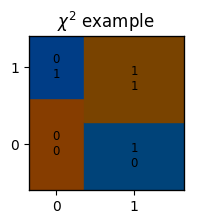

In [108]:
from statsmodels.graphics.mosaicplot import mosaic

data_dart = np.array(
    [
        [30,20],
        [40,50]
    ]
)
fig, ax = plt.subplots(figsize=(2,2))
mosaic(data_dart, title=r'$\chi^2$ example', statistic=True, ax=ax);

In [115]:
# expected values
print(sm.stats.Table(data_dart).fittedvalues)

[[25. 25.]
 [45. 45.]]


In [113]:
print(sm.stats.Table(data_dart).test_nominal_association())

df          1
pvalue      0.07775989643932946
statistic   3.1111111111111107


Independence is the property that the row and column factors occur independently. Association is the lack of independence.  
If the rows and columns of a table are unordered (i.e. are nominal factors), then the most common approach for formally assessing independence is using Pearson's $\chi^2$ statistic.  
The P value is above the traditional threshold of 0.05 so that, the conclusion is that a difference is not detected between the rates in the treated group as compared to the control.

#### Using scipy.stats

In [62]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table)

print(f"chi² = {chi2:.3f}")
print(f"P value = {p:.5f}")
print(f"with {dof} degrees of freedom")

print("expected counts are:")
print(expected)

chi² = 16.176
P value = 0.00031
with 2 degrees of freedom
expected counts are:
[[ 88.03672316  26.96327684]
 [101.81638418  31.18361582]
 [ 81.14689266  24.85310734]]


## Case-control studies

Two groups of subjects:
- incident **cases**, with a **disease** or condition
- **controls**, selected from the same population that produced the cases

For example we can ask whether people with cholera are less likely to have been vaccinated than those who have not gotten cholera. We set the column totals by choosing how many cases and controls top study, and then determined whether each person had been previously vaccinated.

| vaccine | cases | controls |
| ------- |:-----:|:--------:|
| yes     |  10   |    94    |
| no      |  33   |    78    |
| total   |  43   |   172    |

Computing risks and the relative risk directly from a case-control study is invalid because it depends on the total number of controls.

Results from a case-control study are summarized as an **odds ratio** which compares the **odds of exposure** (vaccination) in cases and controls. _The odds ratio equals the odds of the cases having been exposed to the possible risk factor, divided by the odds of the controls having been exposed_. Below the odds ratio of 0.25 quantifies the reduced odds of cholera among those who are vaccinated. We can conclude that a vaccinated person has 25% the chance of an unvaccinated person getting disease, or the vaccine is 75% effective in preventing disease.

The Odds Ratio from a case-control study is almost always a good estimate of the Relative Risk. The Odds Ratio can be only interpret as Relative Risks when the **disease is rare**. But in fact OR can be interpreted as RR in most but not all case-control studies even those of common diseases.

In [30]:
print(f"Odds ratio = {(10/33)/(94/78):.3f}")

Odds ratio = 0.251


In [31]:
sm.stats.Table2x2(
    [
        [10, 94],
        [33, 78]
    ]
).summary(method='normal')

,Estimate,SE,LCB,UCB,p-value
Odds ratio,0.251,,0.117,0.542,0.000
Log odds ratio,-1.381,0.392,-2.149,-0.612,0.000
Risk ratio,0.323,,0.168,0.623,0.001
Log risk ratio,-1.129,0.334,-1.784,-0.474,0.001
